In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
import os
from torch.utils.data import Dataset
from PIL import Image

In [2]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,4,stride,1,bias=True,padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        return self.conv(x)

Discriminator
- Upsampling from 64, 128, 256 and 512

In [3]:
class Discriminator(nn.Module):
    def __init__(self,in_channels=3,features=[64,128,256,512]):
        super().__init__()
        self.initial=nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect"
            ),
            nn.LeakyReLU(0.2)
        )
        layers=[]
        in_channels=features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels,feature,stride=1 if feature==features[-1] else 2))
            in_channels=feature
        layers.append(nn.Conv2d(in_channels,1,kernel_size=4,stride=1,padding=1,padding_mode="reflect"))
        self.model=nn.Sequential(*layers)
    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))
        

Generator
- Downsampling and Instance Normalization

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Initial convolution block
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Downsampling
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            # Residual blocks
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),

            # Upsampling
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Output layer
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.res = nn.Sequential(nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels),
                                 nn.ReLU(inplace=True),
                                 nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels))

    def forward(self, x):
        return x + self.res(x)

In [6]:
# Root directory for dataset
dataroot = "/kaggle/input/gan-getting-started"
# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 5
# Spatial size of training images. All images will be resized to this
# size using a transformer.
image_size = 256

num_epochs = 200
lr_constant_epochs = 100
# Learning rate for optimizers
lr_d = 0.0002
lr_g = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# loss hyper parameter
l = 10 # lambda

In [7]:
class MonetPhotoDataset(Dataset):
    def __init__(self, data_dir, mode='train', transforms=None):
        monet_dir = os.path.join(data_dir, 'monet_jpg')
        photo_dir = os.path.join(data_dir, 'photo_jpg')
        
        if mode == 'train':
            self.monet = [os.path.join(monet_dir, name) for name in sorted(os.listdir(monet_dir))[:295]]
            self.photo = [os.path.join(photo_dir, name) for name in sorted(os.listdir(photo_dir))[:295]]
        elif mode == 'test':
            self.monet = [os.path.join(monet_dir, name) for name in sorted(os.listdir(monet_dir))[295:]]
            self.photo = [os.path.join(photo_dir, name) for name in sorted(os.listdir(photo_dir))[295:301]]
        
        self.transforms = transforms
        
    def __len__(self):
        return len(self.monet)
    
    def __getitem__(self, index):
        monet = self.monet[index]
        photo = self.photo[index]
        
        monet = Image.open(monet)
        photo = Image.open(photo)
        
        if self.transforms is not None:
            monet = self.transforms(monet)
            photo = self.transforms(photo)
        
        return monet, photo

In [8]:
dset_trans = transforms.Compose([
                transforms.Resize(image_size),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])

dataset = MonetPhotoDataset(dataroot,"train",dset_trans)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

test_dataset = MonetPhotoDataset(dataroot,"test",dset_trans)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=workers)

In [9]:
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.functional import pad
from torch.nn.modules import Module
from torch.nn.modules.utils import _single, _pair, _triple

def conv2d_same_padding(input, weight, bias=None, stride=1, padding=1, dilation=1, groups=1, padding_mode = "constant"):
    input_rows = input.size(2)
    filter_rows = weight.size(2)
    effective_filter_size_rows = (filter_rows - 1) * dilation[0] + 1
    out_rows = (input_rows + stride[0] - 1) // stride[0]
    padding_rows = max(0, (out_rows - 1) * stride[0] +
                        (filter_rows - 1) * dilation[0] + 1 - input_rows)
    rows_odd = (padding_rows % 2 != 0)
    padding_cols = max(0, (out_rows - 1) * stride[0] +
                        (filter_rows - 1) * dilation[0] + 1 - input_rows)
    cols_odd = (padding_rows % 2 != 0)
 
    if rows_odd or cols_odd:
        input = pad(input, [0, int(cols_odd), 0, int(rows_odd)], mode=padding_mode)
 
    return F.conv2d(input, weight, bias, stride,
                  padding=(padding_rows // 2, padding_cols // 2),
                  dilation=dilation, groups=groups)
 
class _ConvNd(Module):
 
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dilation, transposed, output_padding, groups, bias):
        super(_ConvNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        if transposed:
            self.weight = Parameter(torch.Tensor(
                in_channels, out_channels // groups, *kernel_size))
        else:
            self.weight = Parameter(torch.Tensor(
                out_channels, in_channels // groups, *kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
 
    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
 
    def __repr__(self):
        s = ('{name}({in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        s += ')'
        return s.format(name=self.__class__.__name__, **self.__dict__)


In [10]:
class Conv2dWithSamePadding(_ConvNd): 
 
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True, padding_mode = "zero"):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(Conv2dWithSamePadding, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias)
        self.padding_mode = padding_mode
        if self.padding_mode == "zero":
            self.padding_mode == "constant"
 
    def forward(self, x):
        return conv2d_same_padding(x, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups,self.padding_mode)

In [11]:
def weights_init(m):
    if isinstance(m, Conv2dWithSamePadding):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [12]:
# Create the generator

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

netG_Photo2Monet = Generator().to(device)
netG_Monet2Photo = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG_Photo2Monet.apply(weights_init)
netG_Monet2Photo.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (res): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Conv

In [13]:
netD_Photo2Monet = Discriminator().to(device)
netD_Monet2Photo = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netD_Photo2Monet.apply(weights_init)
netD_Monet2Photo.apply(weights_init)

Discriminator(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model): Sequential(
    (0): Block(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): Block(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): Block(
      (conv): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(512, eps=1e-05, momentum

In [14]:
# optimizer and other setup
# Initialize BCELoss function
from torch import optim
from itertools import chain
criterion_GAN = nn.MSELoss()
#criterion_GAN = nn.BCEWithLogitsLoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Establish convention for real and fake labels during training
real_label = .9
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD_Photo2Monet = optim.Adam(netD_Photo2Monet.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerD_Monet2Photo = optim.Adam(netD_Monet2Photo.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(chain(netG_Photo2Monet.parameters(), netG_Monet2Photo.parameters()), lr=lr_g, betas=(beta1, 0.999))

In [15]:
print(device)

cuda:0


Starting Training Loop...


  4%|▍         | 9/200 [14:59<5:16:22, 99.39s/it]

epoch 10
discriminator loss: phtot2monet: 0.2731393873691559, monet2photo: 0.25179845094680786, total loss: 0.5249378383159637
generator loss: GAN: 0.8348439335823059, cycle: 0.3634340167045593, identity: 0.3284611105918884
generating images by generators in epoch 10


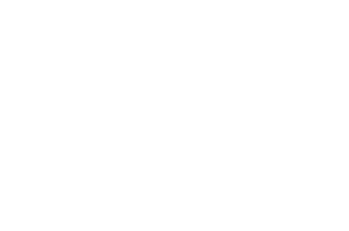

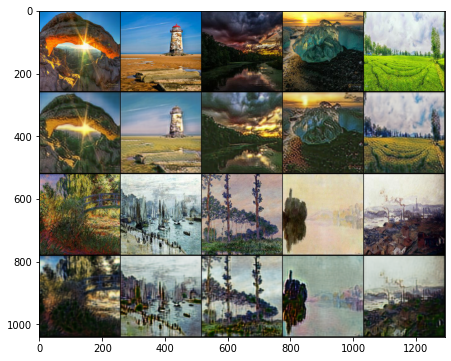

 10%|▉         | 19/200 [31:34<4:59:30, 99.28s/it]

epoch 20
discriminator loss: phtot2monet: 0.22224241495132446, monet2photo: 0.16878798604011536, total loss: 0.3910304009914398
generator loss: GAN: 0.7893418669700623, cycle: 0.3881899118423462, identity: 0.3745154142379761
generating images by generators in epoch 20


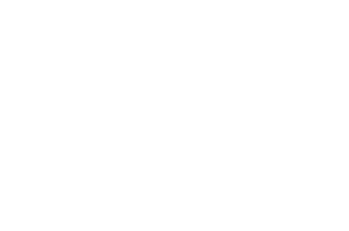

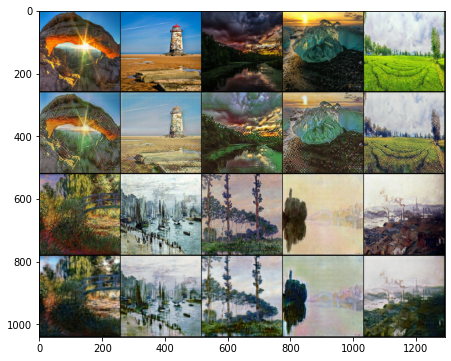

 14%|█▍        | 29/200 [48:10<4:43:37, 99.52s/it]

epoch 30
discriminator loss: phtot2monet: 0.11571149528026581, monet2photo: 0.36545246839523315, total loss: 0.48116396367549896
generator loss: GAN: 0.7722347378730774, cycle: 0.3270651698112488, identity: 0.31239867210388184
generating images by generators in epoch 30


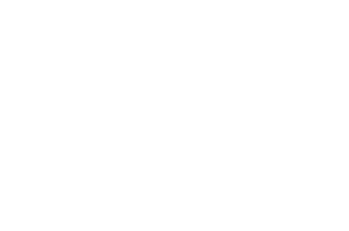

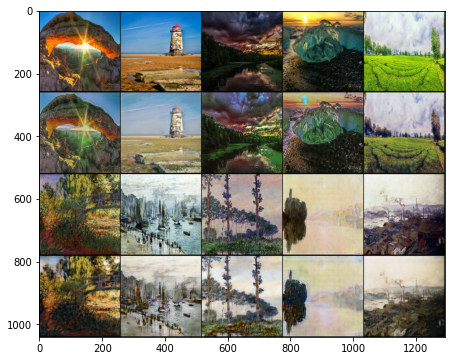

 20%|█▉        | 39/200 [1:04:44<4:26:44, 99.41s/it]

epoch 40
discriminator loss: phtot2monet: 0.3132844865322113, monet2photo: 0.2989772856235504, total loss: 0.6122617721557617
generator loss: GAN: 0.7688175439834595, cycle: 0.3098253309726715, identity: 0.3044206202030182
generating images by generators in epoch 40


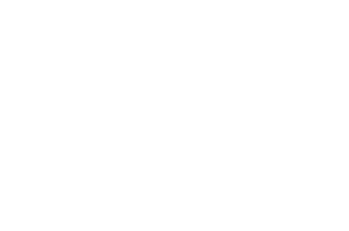

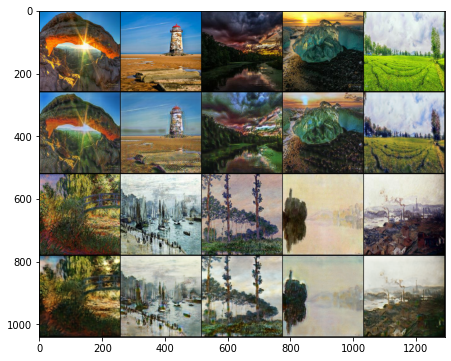

 24%|██▍       | 49/200 [1:21:22<4:11:03, 99.76s/it]

epoch 50
discriminator loss: phtot2monet: 0.19752129912376404, monet2photo: 0.30145615339279175, total loss: 0.4989774525165558
generator loss: GAN: 0.8261523246765137, cycle: 0.3168790340423584, identity: 0.23354563117027283
generating images by generators in epoch 50


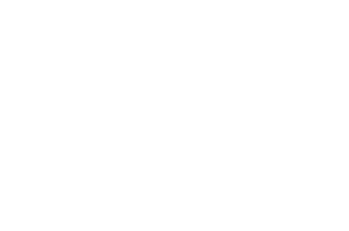

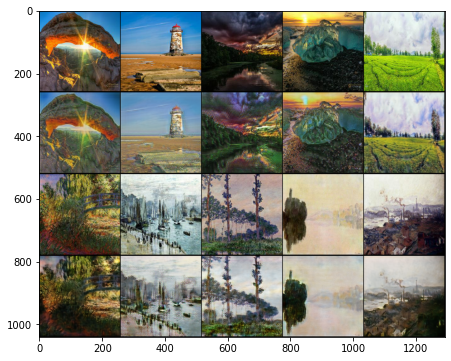

 30%|██▉       | 59/200 [1:37:58<3:53:31, 99.38s/it]

epoch 60
discriminator loss: phtot2monet: 0.07720542699098587, monet2photo: 0.22129592299461365, total loss: 0.2985013499855995
generator loss: GAN: 1.0333954095840454, cycle: 0.257404625415802, identity: 0.24316060543060303
generating images by generators in epoch 60


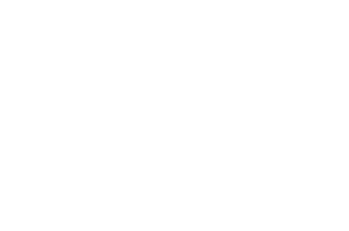

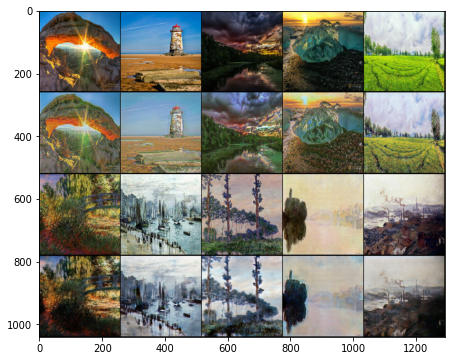

 34%|███▍      | 69/200 [1:54:32<3:35:55, 98.90s/it]

epoch 70
discriminator loss: phtot2monet: 0.11627679318189621, monet2photo: 0.16189372539520264, total loss: 0.27817051857709885
generator loss: GAN: 1.037681221961975, cycle: 0.22182448208332062, identity: 0.24783939123153687
generating images by generators in epoch 70


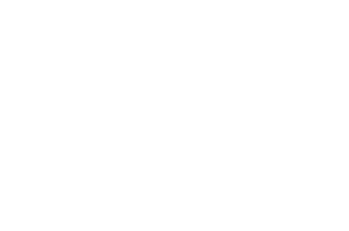

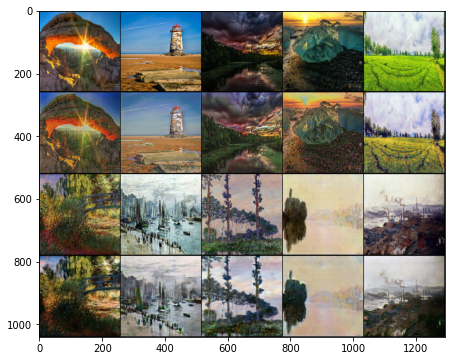

 40%|███▉      | 79/200 [2:11:04<3:20:05, 99.22s/it]

epoch 80
discriminator loss: phtot2monet: 0.09403737634420395, monet2photo: 0.10558976233005524, total loss: 0.19962713867425919
generator loss: GAN: 1.0413554906845093, cycle: 0.24343106150627136, identity: 0.23500537872314453
generating images by generators in epoch 80


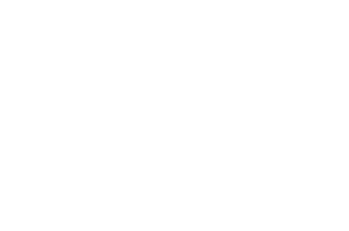

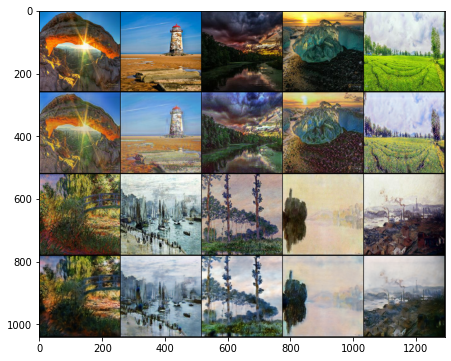

 44%|████▍     | 89/200 [2:27:37<3:03:26, 99.15s/it]

epoch 90
discriminator loss: phtot2monet: 0.11963193118572235, monet2photo: 0.22460997104644775, total loss: 0.3442419022321701
generator loss: GAN: 0.8279701471328735, cycle: 0.31029874086380005, identity: 0.28334176540374756
generating images by generators in epoch 90


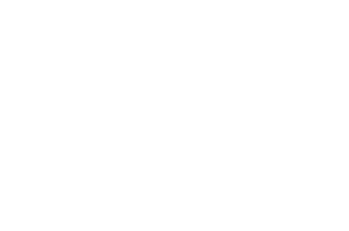

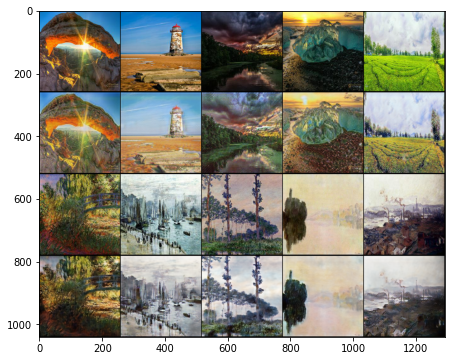

 50%|████▉     | 99/200 [2:44:10<2:46:52, 99.14s/it]

epoch 100
discriminator loss: phtot2monet: 0.025321274995803833, monet2photo: 0.11124654114246368, total loss: 0.13656781613826752
generator loss: GAN: 1.1305291652679443, cycle: 0.2099420428276062, identity: 0.17624984681606293
generating images by generators in epoch 100


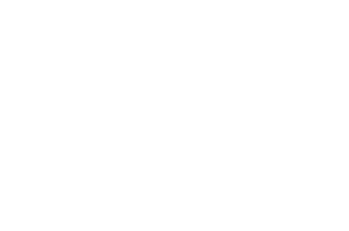

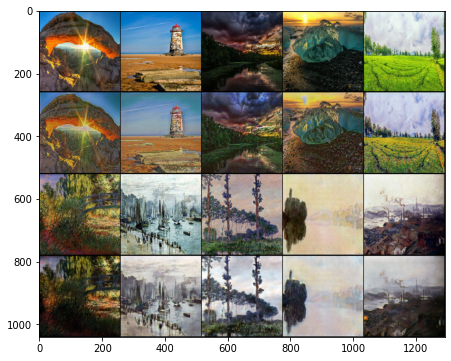

 55%|█████▍    | 109/200 [3:00:44<2:30:23, 99.16s/it]

epoch 110
discriminator loss: phtot2monet: 0.01686534471809864, monet2photo: 0.162657231092453, total loss: 0.17952257581055164
generator loss: GAN: 1.2581491470336914, cycle: 0.21584001183509827, identity: 0.21011218428611755
generating images by generators in epoch 110


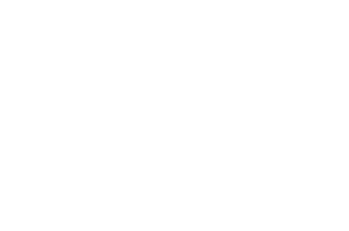

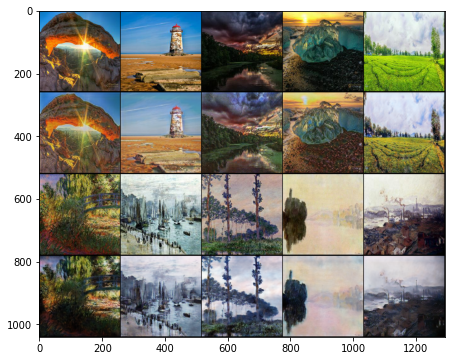

 60%|█████▉    | 119/200 [3:17:15<2:13:45, 99.08s/it]

epoch 120
discriminator loss: phtot2monet: 0.06759517639875412, monet2photo: 0.20050784945487976, total loss: 0.2681030258536339
generator loss: GAN: 1.019068956375122, cycle: 0.23178236186504364, identity: 0.21198983490467072
generating images by generators in epoch 120


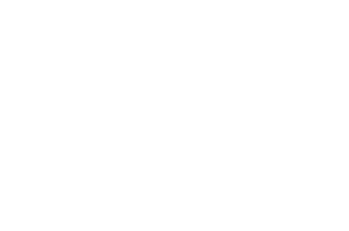

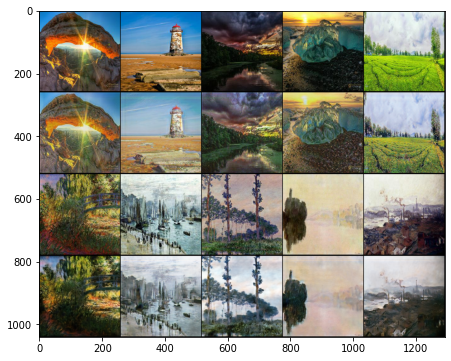

 64%|██████▍   | 129/200 [3:33:45<1:57:02, 98.91s/it]

epoch 130
discriminator loss: phtot2monet: 0.03536199405789375, monet2photo: 0.2542196810245514, total loss: 0.28958167508244514
generator loss: GAN: 1.1042413711547852, cycle: 0.17644831538200378, identity: 0.16875526309013367
generating images by generators in epoch 130


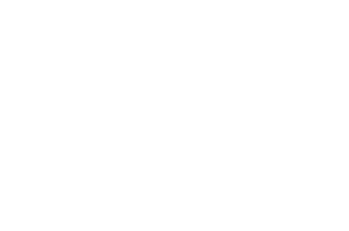

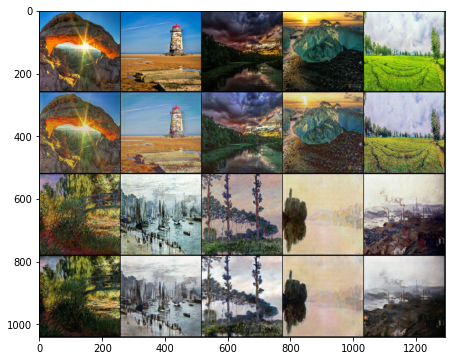

 70%|██████▉   | 139/200 [3:50:18<1:40:47, 99.13s/it]

epoch 140
discriminator loss: phtot2monet: 0.0639856830239296, monet2photo: 0.21136030554771423, total loss: 0.27534598857164383
generator loss: GAN: 1.035965919494629, cycle: 0.18872115015983582, identity: 0.1841212511062622
generating images by generators in epoch 140


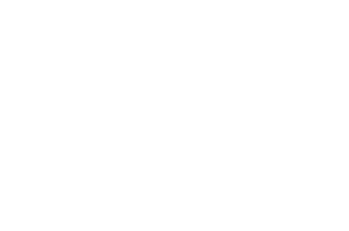

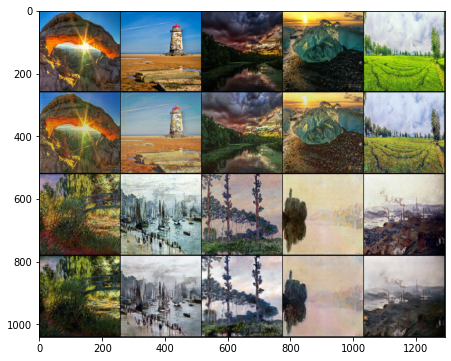

 74%|███████▍  | 149/200 [4:06:49<1:24:08, 98.99s/it]

epoch 150
discriminator loss: phtot2monet: 0.014535265043377876, monet2photo: 0.07999687641859055, total loss: 0.09453214146196842
generator loss: GAN: 1.3157271146774292, cycle: 0.16788479685783386, identity: 0.15375787019729614
generating images by generators in epoch 150


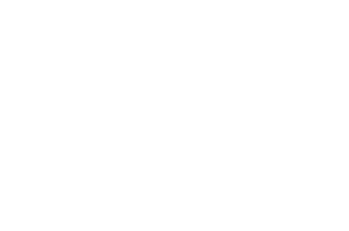

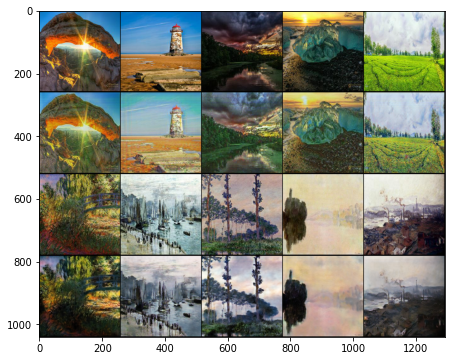

 80%|███████▉  | 159/200 [4:23:22<1:07:48, 99.23s/it]

epoch 160
discriminator loss: phtot2monet: 0.041801221668720245, monet2photo: 0.08495672047138214, total loss: 0.1267579421401024
generator loss: GAN: 1.2984395027160645, cycle: 0.19138631224632263, identity: 0.17206120491027832
generating images by generators in epoch 160


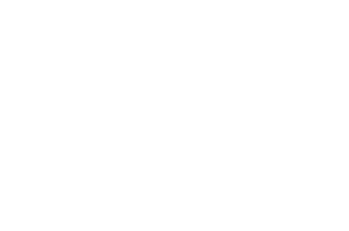

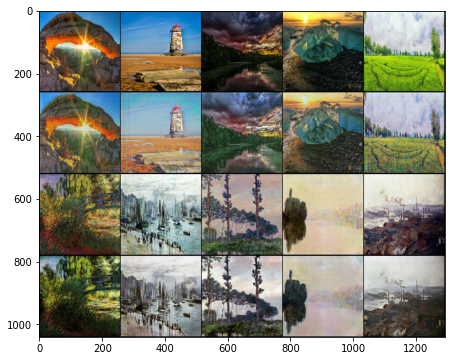

 84%|████████▍ | 169/200 [4:39:55<51:12, 99.10s/it]

epoch 170
discriminator loss: phtot2monet: 0.12095076590776443, monet2photo: 0.05110529065132141, total loss: 0.17205605655908585
generator loss: GAN: 1.3612838983535767, cycle: 0.17071211338043213, identity: 0.15230286121368408
generating images by generators in epoch 170


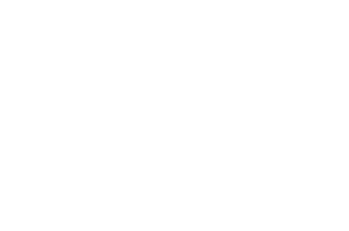

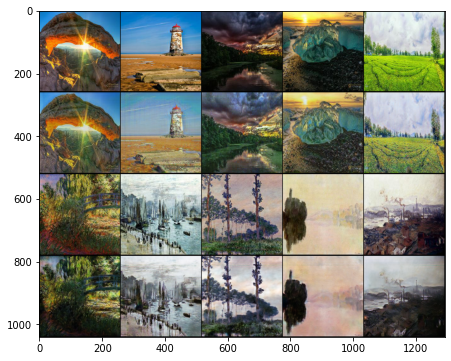

 90%|████████▉ | 179/200 [4:56:26<34:39, 99.04s/it]

epoch 180
discriminator loss: phtot2monet: 0.2297210991382599, monet2photo: 0.14888229966163635, total loss: 0.37860339879989624
generator loss: GAN: 1.3422720432281494, cycle: 0.18691787123680115, identity: 0.17190855741500854
generating images by generators in epoch 180


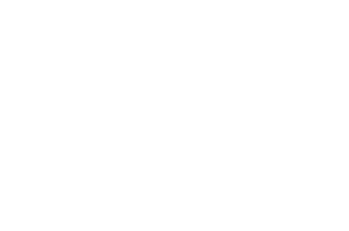

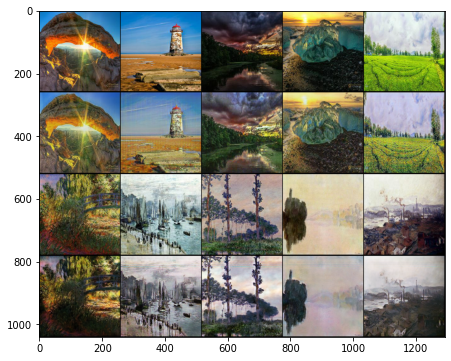

 94%|█████████▍| 189/200 [5:13:01<18:11, 99.25s/it]

epoch 190
discriminator loss: phtot2monet: 0.15284386277198792, monet2photo: 0.18479236960411072, total loss: 0.33763623237609863
generator loss: GAN: 1.051605224609375, cycle: 0.1697635054588318, identity: 0.14273855090141296
generating images by generators in epoch 190


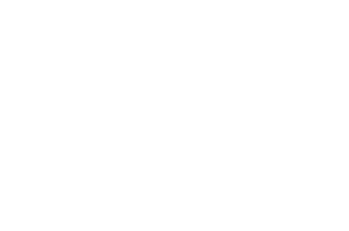

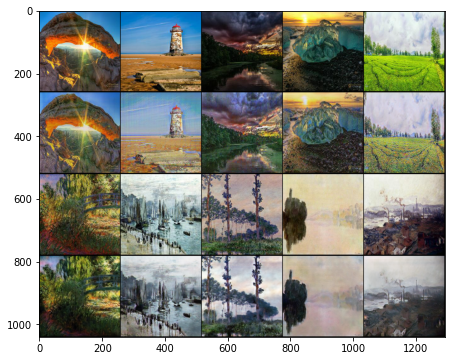

100%|█████████▉| 199/200 [5:29:37<01:39, 99.73s/it]

epoch 200
discriminator loss: phtot2monet: 0.1865810751914978, monet2photo: 0.08005410432815552, total loss: 0.2666351795196533
generator loss: GAN: 1.153238296508789, cycle: 0.16390550136566162, identity: 0.13554216921329498
generating images by generators in epoch 200


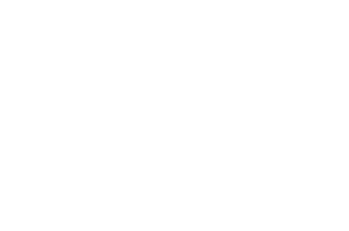

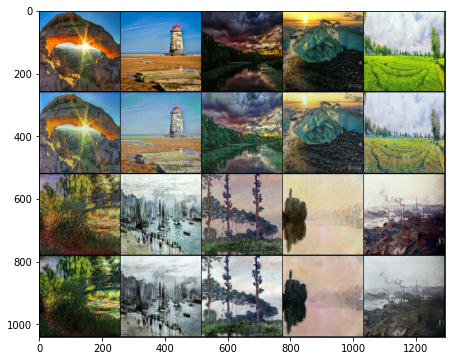

100%|██████████| 200/200 [5:31:17<00:00, 99.39s/it] 


In [16]:
# Training Loop
import torchvision.utils as vutils
from tqdm import tqdm
import numpy as np
torch.autograd.set_detect_anomaly(True)
# Lists to keep track of progress
img_list_monet = []
img_list_photo = []
loss_d = []
loss_g = []
from tqdm import tqdm
print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(num_epochs)):
    # For each batch in the dataloader
    netD_Monet2Photo.train()
    netD_Photo2Monet.train()
    netG_Monet2Photo.train()
    netG_Photo2Monet.train()
    
    for i, data in enumerate(dataloader, 0):
        ############################
        # objective function: L(Gx2y,Gy2x,Dy,Dx) = L1(Gx2y,Dy,x,y) + L2(Gy2x,Dx,x,y) + lambda1 * L3(G,F) + lambda2 * L4(G,F)
        # L1, L2: the original loss of GANs, here using MSE loss
        # L3: cycle loss, here using L1 loss
        # L4: identity loss, here using L1 loss
        # here, lambda2 = 0.5 * lambda1
        ############################
        data_monet = data[0].to(device)
        data_photo = data[1].to(device)
        b_size = data_monet.size(0)
        label_real = torch.full((b_size,1,30,30), real_label, dtype=torch.float, device=device)
        label_fake = torch.full((b_size,1,30,30), fake_label, dtype=torch.float, device=device)
        
        ############################
        # (1) Update generators: 
        ###########################
        netG_Monet2Photo.zero_grad()
        netG_Photo2Monet.zero_grad()
        
        Monet_from_photo = netG_Photo2Monet(data_photo)
        photo_from_monet = netG_Monet2Photo(data_monet)

        # GAN loss
        GAN_loss_Photo2Monet = criterion_GAN(netD_Photo2Monet(Monet_from_photo), label_real)
        GAN_loss_Monet2Photo = criterion_GAN(netD_Monet2Photo(photo_from_monet), label_real)
        GAN_loss = (GAN_loss_Photo2Monet + GAN_loss_Monet2Photo)

        # cycle loss
        monet2photo2monet = netG_Photo2Monet(photo_from_monet)
        photo2monet2photo = netG_Monet2Photo(Monet_from_photo)
        cycle_loss_Photo2Monet = criterion_cycle(photo2monet2photo, data_photo)
        cycle_loss_Monet2Photo = criterion_cycle(monet2photo2monet, data_monet)
        cycle_loss = (cycle_loss_Photo2Monet + cycle_loss_Monet2Photo)

        # identity loss (need to check more)
        monet_from_photo_by_net_p2m = netG_Photo2Monet(data_monet)
        photo_from_monet_by_net_m2p = netG_Monet2Photo(data_photo)
        identity_loss_p2m = criterion_identity(monet_from_photo_by_net_p2m, data_monet)
        identity_loss_m2p = criterion_identity(photo_from_monet_by_net_m2p, data_photo)
        identity_loss = (identity_loss_m2p + identity_loss_p2m)

        # update paramenter
        total_loss_G = GAN_loss + l * cycle_loss + 0.5 * l * identity_loss
        total_loss_G.backward()
        optimizerG.step()
        
        ############################
        # (2) Update discriminators: 
        ###########################
        
        netD_Monet2Photo.zero_grad()
        netD_Photo2Monet.zero_grad()
        
        total_d_loss = 0.
        
        # training the discriminator (Photo2Monet)
        output_real = netD_Photo2Monet(data_monet)
        output_fake = netD_Photo2Monet(Monet_from_photo.detach())
        loss_real = criterion_GAN(output_real, label_real)
        loss_fake = criterion_GAN(output_fake, label_fake)
        loss_photo2Monet = (loss_real + loss_fake)
        total_d_loss = total_d_loss + loss_photo2Monet.item()
        loss_photo2Monet.backward()
        optimizerD_Photo2Monet.step()

        # traning the discriminator (Monet2Photo)
        output_real = netD_Monet2Photo(data_photo)
        output_fake = netD_Monet2Photo(photo_from_monet.detach())
        loss_real = criterion_GAN(output_real, label_real)
        loss_fake = criterion_GAN(output_fake, label_fake)
        loss_Monet2Photo = (loss_real + loss_fake)
        total_d_loss = total_d_loss + loss_Monet2Photo.item()
        loss_Monet2Photo.backward()
        optimizerD_Monet2Photo.step()
        
    loss_d.append(total_d_loss)
    loss_g.append(total_loss_G.item())

    if ((epoch+1) % 10) == 0:
        print(f"epoch {epoch + 1}")
        # print losses
        print(f"discriminator loss: phtot2monet: {loss_photo2Monet.item()}, monet2photo: {loss_Monet2Photo.item()}, total loss: {total_d_loss}")
        print(f"generator loss: GAN: {GAN_loss.item()}, cycle: {cycle_loss.item()}, identity: {identity_loss.item()}")
        print(f"generating images by generators in epoch {epoch+1}")
        # Checking both generators and visulization
        netG_Monet2Photo.eval()
        netG_Photo2Monet.eval()

        ts_data = next(iter(test_dataloader))

        ts_monet_data = ts_data[0].to(device)
        ts_photo_data = ts_data[1].to(device)

        monet = netG_Photo2Monet(ts_photo_data).detach()
        photo = netG_Monet2Photo(ts_monet_data).detach()

        nrows = ts_monet_data.size(0)

        ts_photo_data = make_grid(ts_photo_data, nrow=nrows, normalize=True)
        ts_monet_data = make_grid(ts_monet_data, nrow=nrows, normalize=True)
        monet = make_grid(monet, nrow=nrows, normalize=True)
        photo = make_grid(photo, nrow=nrows, normalize=True)

        result = torch.cat((ts_photo_data, monet, ts_monet_data, photo), 1)
        result = result.cpu().permute(1,2,0)

        # show images 
        plt.axis("off")
        plt.figure(figsize=(1.5*nrows, 6))
        plt.imshow(result)
        plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


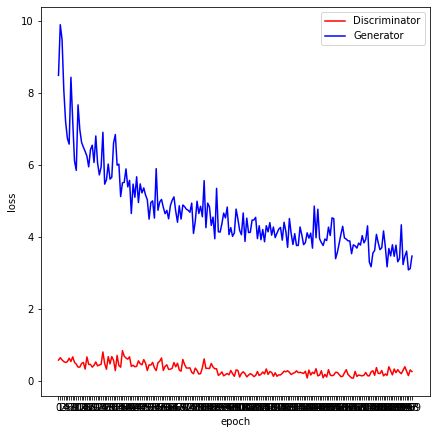

In [17]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
x_epoch = np.arange(0, len(loss_d)).astype(dtype=np.str)
ax.plot(x_epoch, loss_d, 'r',label="Discriminator")
ax.plot(x_epoch, loss_g, 'b',label="Generator")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()
plt.show()

In [18]:
# generating images and save them, waiting for metric
photo_dir = os.path.join(dataroot, 'photo_jpg')
files = [os.path.join(photo_dir, name) for name in os.listdir(photo_dir)]
len(files)

7038

In [19]:
save_dir = '/kaggle/images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [20]:
generate_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

to_image = transforms.ToPILImage()

netG_Photo2Monet.eval()
for i in range(0, len(files), batch_size):
    # read images
    imgs = []
    for j in range(i, min(len(files), i+batch_size)):
        img = Image.open(files[j])
        img = generate_transforms(img)
        imgs.append(img)
    imgs = torch.stack(imgs, 0).to(device)
    
    # generate
    fake_imgs = netG_Photo2Monet(imgs).detach().cpu()
    
    # save
    for j in range(fake_imgs.size(0)):
        img = fake_imgs[j].squeeze().permute(1, 2, 0)
        img_arr = img.numpy()
        img_arr = (img_arr - np.min(img_arr)) * 255 / (np.max(img_arr) - np.min(img_arr))
        img_arr = img_arr.astype(np.uint8)
        
        img = to_image(img_arr)
        _, name = os.path.split(files[i+j])
        img.save(os.path.join(save_dir, name))

In [21]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")
print("finished!")

finished!
